# Earthquake Prediction

In [199]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [200]:
filepath = './data/earthquakes.csv'

In [201]:
df = pd.read_csv(filepath)
df = df[df.mag.notna()]
df.time = pd.to_datetime(df.time)
df = df[::-1]
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
35244,2020-07-12 10:31:53.318000+00:00,67.791600,-158.636400,15.00,1.10,ml,NaN,NaN,NaN,0.42,...,2020-08-04T02:49:26.410Z,"85 km NNW of Ambler, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
35243,2020-07-12 10:38:04.580000+00:00,33.177833,-116.127833,11.36,0.72,ml,35.0,60.0,0.040210,0.19,...,2020-07-13T22:21:26.937Z,"4km N of Ocotillo Wells, CA",earthquake,0.24,0.34,0.158,12.0,reviewed,ci,ci
35242,2020-07-12 10:38:50.280000+00:00,38.816334,-122.813500,3.17,0.91,md,22.0,46.0,0.007542,0.02,...,2020-07-12T11:51:04.930Z,"7km NW of The Geysers, CA",earthquake,0.26,0.50,0.130,3.0,automatic,nc,nc
35241,2020-07-12 10:40:29.962000+00:00,63.047100,-150.433700,107.20,1.10,ml,NaN,NaN,NaN,0.21,...,2020-08-04T02:49:33.285Z,"63 km NNE of Petersville, Alaska",earthquake,NaN,0.50,NaN,NaN,reviewed,ak,ak
35240,2020-07-12 10:50:55.660000+00:00,36.073167,-117.642167,4.75,0.88,ml,13.0,85.0,0.110600,0.14,...,2020-07-12T16:37:38.032Z,"28km E of Coso Junction, CA",earthquake,0.27,2.64,0.189,9.0,reviewed,ci,ci


In [202]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,35244.000000,35244.000000,35244.000000,35244.000000,28038.000000,29241.000000,24218.000000,35244.000000,24989.000000,35244.000000,26445.000000,27361.000000
mean,37.167249,-108.586930,21.478567,1.663011,23.384443,116.452087,0.816648,0.275342,1.929334,4.240669,0.252210,17.163664
std,19.093721,67.752118,54.360684,1.311471,21.687801,60.420181,2.755295,0.272877,3.300874,389.384796,0.461743,34.172450
min,-65.352200,-179.996400,-3.730000,-1.430000,0.000000,11.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,33.419542,-149.703350,3.600000,0.800000,10.000000,71.000000,0.025000,0.100000,0.280000,0.470000,0.103000,5.000000
50%,38.151200,-118.777667,8.000000,1.340000,17.000000,102.000000,0.059583,0.160000,0.480000,0.800000,0.160000,9.000000
75%,47.512008,-113.777417,14.560000,2.110000,29.000000,150.000000,0.165825,0.400000,1.090000,1.780000,0.236000,18.000000
max,87.349200,180.000000,647.998000,7.800000,444.000000,355.000000,43.236000,2.460000,26.400000,73091.100000,5.520000,760.000000


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35244 entries, 35244 to 0
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   time             35244 non-null  datetime64[ns, UTC]
 1   latitude         35244 non-null  float64            
 2   longitude        35244 non-null  float64            
 3   depth            35244 non-null  float64            
 4   mag              35244 non-null  float64            
 5   magType          35244 non-null  object             
 6   nst              28038 non-null  float64            
 7   gap              29241 non-null  float64            
 8   dmin             24218 non-null  float64            
 9   rms              35244 non-null  float64            
 10  net              35244 non-null  object             
 11  id               35244 non-null  object             
 12  updated          35244 non-null  object             
 13  place           

In [204]:
df.isnull().sum()

time                   0
latitude               0
longitude              0
depth                  0
mag                    0
magType                0
nst                 7206
gap                 6003
dmin               11026
rms                    0
net                    0
id                     0
updated                0
place                789
type                   0
horizontalError    10255
depthError             0
magError            8799
magNst              7883
status                 0
locationSource         0
magSource              0
dtype: int64

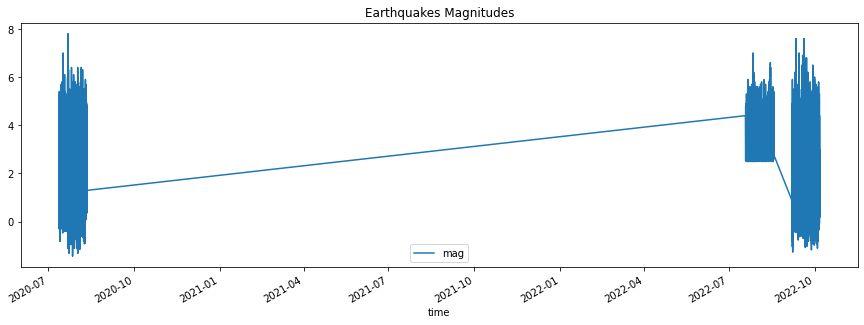

In [205]:
df.plot(figsize=(15, 5), title='Earthquakes Magnitudes', x='time', y='mag')
plt.show()

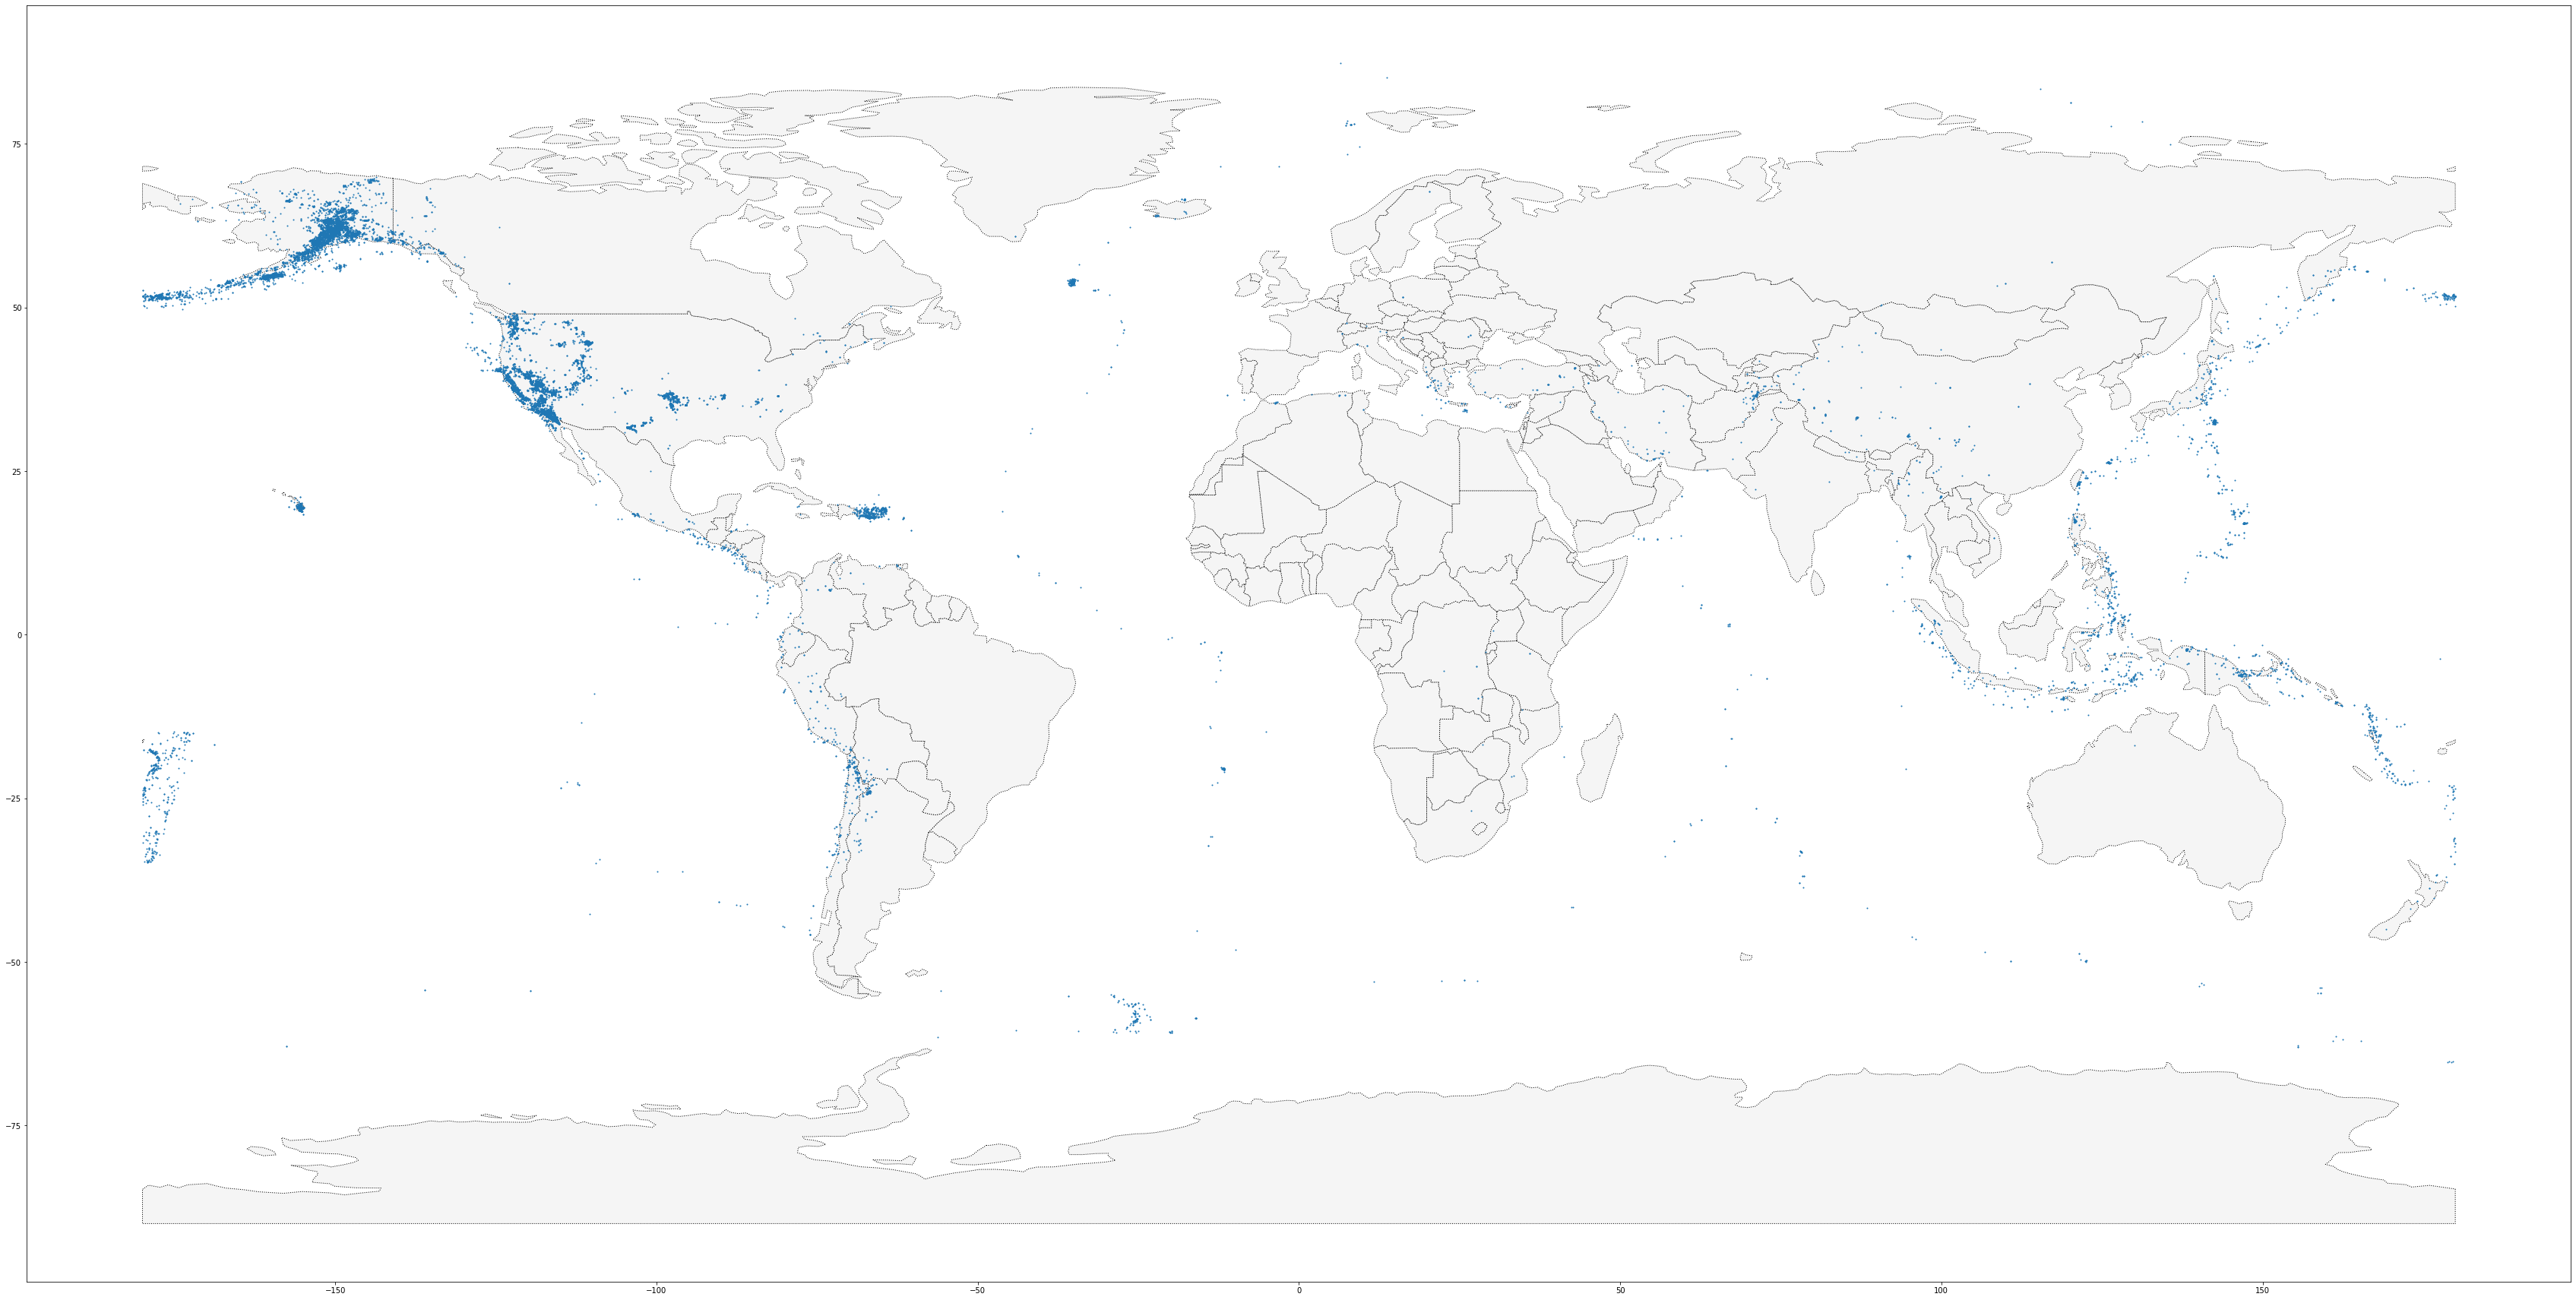

In [206]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [207]:
print(f'Min magnitude: {df.mag.min()}')
print(f'Max magnitude: {df.mag.max()}')

Min magnitude: -1.43
Max magnitude: 7.8


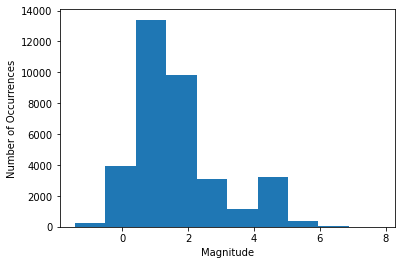

In [208]:
plt.hist(df.mag)
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

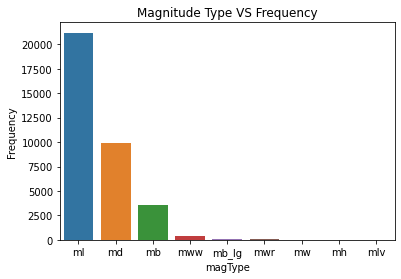

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [209]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [210]:
df.loc[df.mag >= 8, 'Class'] = 'Disastrous'
df.loc[(df.mag >= 7) & (df.mag < 7.9), 'Class'] = 'Major'
df.loc[(df.mag >= 6) & (df.mag < 6.9), 'Class'] = 'Strong'
df.loc[(df.mag >= 5.5) & (df.mag < 5.9), 'Class'] = 'Moderate'

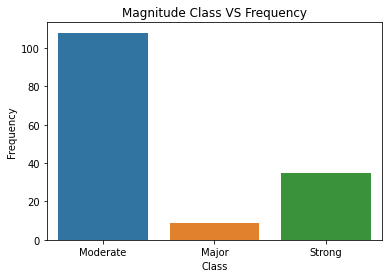

In [211]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

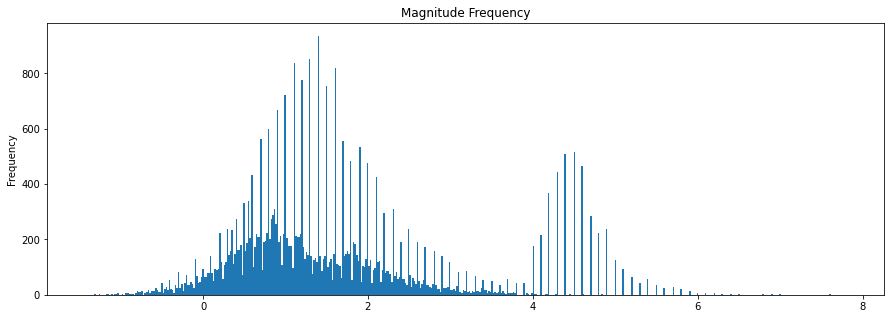

In [212]:
df.mag.plot(kind='hist', bins=500, figsize=(15, 5))
plt.title('Magnitude Frequency')
plt.show()

In [213]:
threshold = 0.9
corr_matrix = df.corr() 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)

/var/folders/5k/d7ys19gs271bht03kns2zr3c0000gn/T/ipykernel_20014/1073417915.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


In [214]:
percent = 30
df = df.dropna(axis=1, thresh=int(((100 - percent) / 100) * df.shape[0] + 1)) 

In [215]:
df = df.copy()
df['location'] = df.place.str.split(', ', expand=True)[1]
df.location.head() 

35244    Alaska
35243        CA
35242        CA
35241    Alaska
35240        CA
Name: location, dtype: object

In [216]:
print(f'Total locations: {df.location.nunique()}')

Total locations: 134


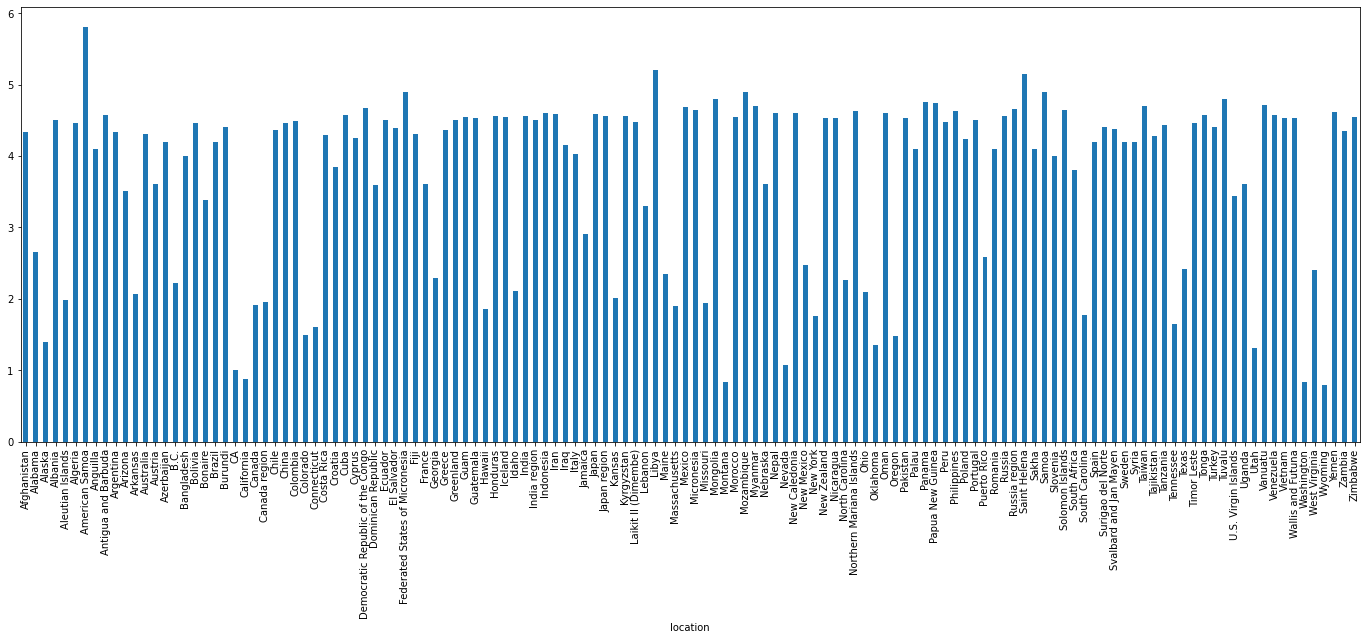

In [217]:
df.groupby(['location'])['mag'].mean().plot(kind='bar',figsize=(24, 8))
plt.show()

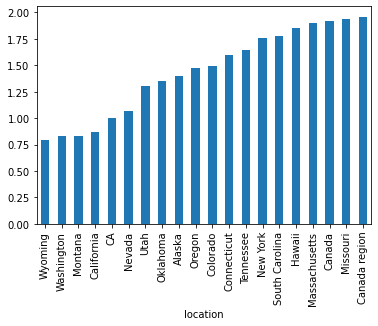

In [218]:
df.groupby(['location'])['mag'].mean().nsmallest(20).plot(kind='bar')
plt.show()

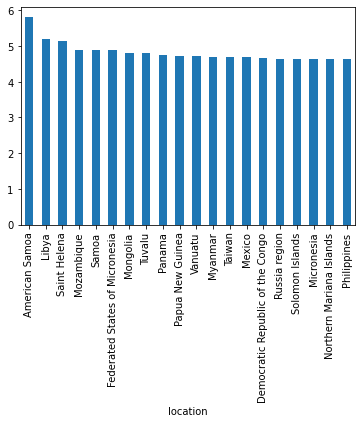

In [219]:
df.groupby(['location'])['mag'].mean().nlargest(20).plot(kind='bar')
plt.show()

In [220]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index."""
    df = df.copy()
    df['hour'] = df.time.dt.hour
    df['dayofweek'] = df.time.dt.dayofweek
    df['month'] = df.time.dt.month
    df['year'] = df.time.dt.year
    df['dayofyear'] = df.time.dt.dayofyear
    df['dayofmonth'] = df.time.dt.day
    df['weekofyear'] = df.time.dt.isocalendar().week
    df['quarter'] = df.time.dt.quarter
    df['season'] = df.month % 12 // 3 + 1
    return df

def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5eq_lag'] = df.mag.shift(5)
    df['mag_10eq_lag'] = df.mag.shift(10)
    df['mag_15eq_lag'] = df.mag.shift(15)

    df['depth_5eq_lag'] = df.depth.shift(5)
    df['depth_10eq_lag'] = df.depth.shift(10)
    df['depth_15eq_lag'] = df.depth.shift(15)
    return df

def add_rolling_windows(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5eq_avg'] = df.mag.rolling(window=5, center=False).mean()
    df['mag_10eq_avg'] = df.mag.rolling(window=10, center=False).mean()
    df['mag_15eq_avg'] = df.mag.rolling(window=15, center=False).mean()
    df['mag_5eq_min'] = df.mag.rolling(window=5, center=False).min()
    df['mag_10eq_min'] = df.mag.rolling(window=10, center=False).min()
    df['mag_15eq_min'] = df.mag.rolling(window=15, center=False).min()
    df['mag_5eq_max'] = df.mag.rolling(window=5, center=False).max()
    df['mag_10eq_max'] = df.mag.rolling(window=10, center=False).max()
    df['mag_15eq_max'] = df.mag.rolling(window=15, center=False).max()
    df['mag_5eq_std'] = df.mag.rolling(window=5, center=False).std()
    df['mag_10eq_std'] = df.mag.rolling(window=10, center=False).std()
    df['mag_15eq_std'] = df.mag.rolling(window=15, center=False).std()

    df['depth_5eq_avg'] = df.depth.rolling(window=5, center=False).mean()
    df['depth_10eq_avg'] = df.depth.rolling(window=10, center=False).mean()
    df['depth_15eq_avg'] = df.depth.rolling(window=15, center=False).mean()
    df['depth_5eq_min'] = df.depth.rolling(window=5, center=False).min()
    df['depth_10eq_min'] = df.depth.rolling(window=10, center=False).min()
    df['depth_15eq_min'] = df.depth.rolling(window=15, center=False).min()
    df['depth_5eq_max'] = df.depth.rolling(window=5, center=False).max()
    df['depth_10eq_max'] = df.depth.rolling(window=10, center=False).max()
    df['depth_15eq_max'] = df.depth.rolling(window=15, center=False).max()
    df['depth_5eq_std'] = df.depth.rolling(window=5, center=False).std()
    df['depth_10eq_std'] = df.depth.rolling(window=10, center=False).std()
    df['depth_15eq_std'] = df.depth.rolling(window=15, center=False).std()
    return df

data = []
for location in df.location.unique():
    temp = df.loc[df.location == location]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_windows(temp)

    data.append(temp)

df = pd.concat(data)

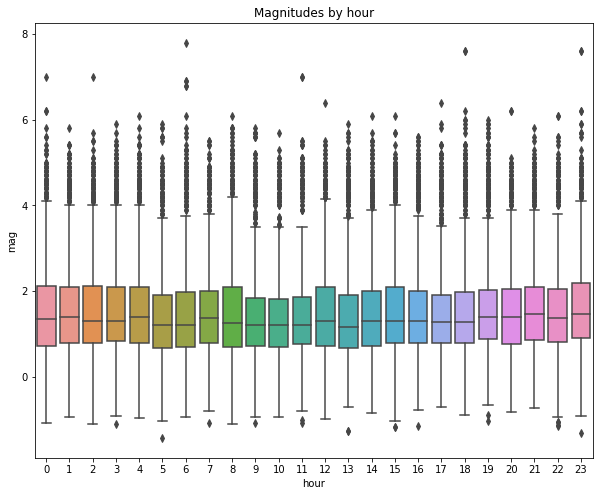

In [221]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='mag')
ax.set_title('Magnitudes by hour')
plt.show()

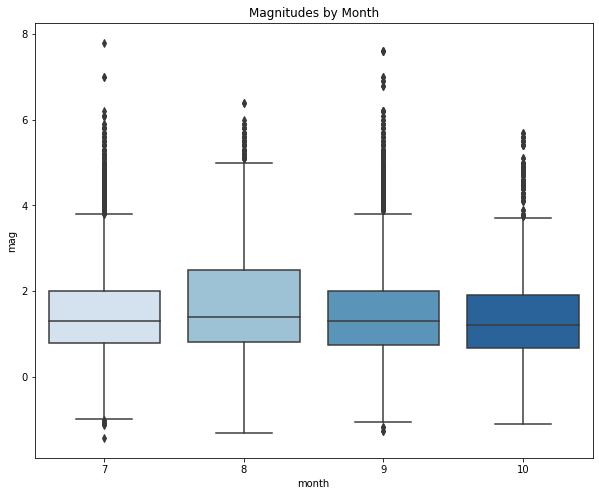

In [222]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='mag', palette='Blues')
ax.set_title('Magnitudes by Month')
plt.show()

In [223]:
features = [
    'dayofyear',
    'hour',
    'dayofweek',
    'month',
    'season',
    'year',
    'mag_5eq_lag',
    'mag_10eq_lag',
    'mag_15eq_lag',
    'mag_5eq_avg',
    'mag_10eq_avg',
    'mag_15eq_avg',
    'mag_5eq_min',
    'mag_10eq_min',
    'mag_15eq_min',
    'mag_5eq_max',
    'mag_10eq_max',
    'mag_15eq_max',
    'mag_5eq_std',
    'mag_10eq_std',
    'mag_15eq_std',
    'depth_5eq_lag',
    'depth_10eq_lag',
    'depth_15eq_lag',
    'depth_5eq_avg',
    'depth_10eq_avg',
    'depth_15eq_avg',
    'depth_5eq_min',
    'depth_10eq_min',
    'depth_15eq_min',
    'depth_5eq_max',
    'depth_10eq_max',
    'depth_15eq_max',
    'depth_5eq_std',
    'depth_10eq_std',
    'depth_15eq_std',
    'latitude',
    'longitude',
]
cat_features = ['location']
target = 'mag'

In [224]:
date = '2022-09-25 00:00:00.000000+00:00'

df_train = df.loc[df.time < date]
df_test = df.loc[df.time >= date]

In [225]:
print(f'Test size: {len(df_test) / (len(df_test) + len(df_train))}')

Test size: 0.20542683682319415


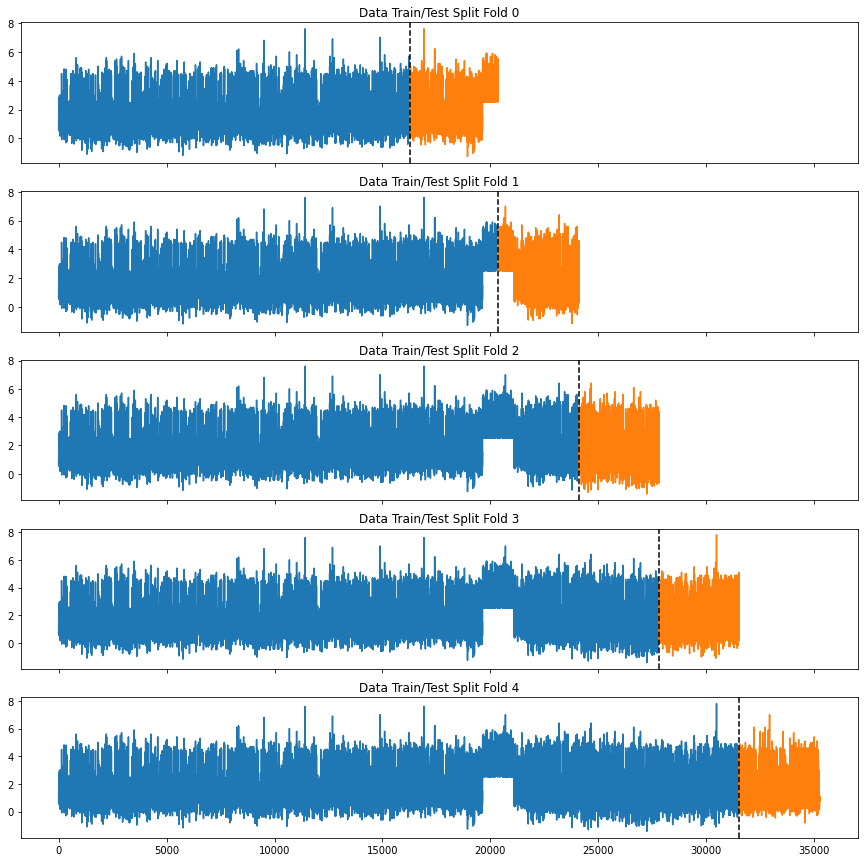

In [226]:
tss = model_selection.TimeSeriesSplit(n_splits=5, test_size=3600, gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train.mag.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test.mag.plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [227]:
fold = 0
predictions = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    x_train = train[features + cat_features]
    y_train = train[target]

    x_test = test[features + cat_features]
    y_test = test[target]

    model = cb.CatBoostRegressor(
        depth=7, 
        learning_rate=0.01, 
        iterations=1000, 
        early_stopping_rounds=50,
        cat_features=cat_features,
    )
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

    y_pred = model.predict(x_test)
    predictions.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.1715721	test: 1.1715721	test1: 1.5351445	best: 1.5351445 (0)	total: 23.6ms	remaining: 23.6s
100:	learn: 0.6882549	test: 0.6882549	test1: 0.7628883	best: 0.7628883 (100)	total: 1.73s	remaining: 15.4s
200:	learn: 0.5549258	test: 0.5549258	test1: 0.5539505	best: 0.5539505 (200)	total: 3.38s	remaining: 13.4s
300:	learn: 0.5130914	test: 0.5130914	test1: 0.5035534	best: 0.5035534 (300)	total: 4.99s	remaining: 11.6s
400:	learn: 0.4927518	test: 0.4927518	test1: 0.4863213	best: 0.4863213 (400)	total: 6.52s	remaining: 9.74s
500:	learn: 0.4778229	test: 0.4778229	test1: 0.4778893	best: 0.4778893 (500)	total: 7.8s	remaining: 7.77s
600:	learn: 0.4648306	test: 0.4648306	test1: 0.4719137	best: 0.4719137 (600)	total: 9.25s	remaining: 6.14s
700:	learn: 0.4537154	test: 0.4537154	test1: 0.4677258	best: 0.4677258 (700)	total: 10.8s	remaining: 4.6s
800:	learn: 0.4436629	test: 0.4436629	test1: 0.4640182	best: 0.4640076 (799)	total: 12.1s	remaining: 3s
900:	learn: 0.4339381	test: 0.4339381	test1: 

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.2461312	test: 1.2461312	test1: 1.4036838	best: 1.4036838 (0)	total: 22.9ms	remaining: 22.9s
100:	learn: 0.7021854	test: 0.7021854	test1: 0.7746606	best: 0.7746606 (100)	total: 1.58s	remaining: 14s
200:	learn: 0.5546319	test: 0.5546319	test1: 0.6181615	best: 0.6181615 (200)	total: 3.2s	remaining: 12.7s
300:	learn: 0.5094693	test: 0.5094693	test1: 0.5872485	best: 0.5872485 (300)	total: 4.81s	remaining: 11.2s
400:	learn: 0.4883567	test: 0.4883567	test1: 0.5803326	best: 0.5803326 (400)	total: 6.79s	remaining: 10.2s
500:	learn: 0.4738643	test: 0.4738643	test1: 0.5769145	best: 0.5769145 (500)	total: 8.43s	remaining: 8.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5767230771
bestIteration = 514

Shrink model to first 515 iterations.


/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.2740596	test: 1.2740596	test1: 1.1117461	best: 1.1117461 (0)	total: 57ms	remaining: 57s
100:	learn: 0.7156211	test: 0.7156211	test1: 0.7499518	best: 0.7499518 (100)	total: 1.87s	remaining: 16.6s
200:	learn: 0.5672096	test: 0.5672096	test1: 0.6630904	best: 0.6628873 (198)	total: 3.82s	remaining: 15.2s
300:	learn: 0.5257113	test: 0.5257113	test1: 0.6517133	best: 0.6490160 (282)	total: 5.59s	remaining: 13s
400:	learn: 0.5053338	test: 0.5053338	test1: 0.6449118	best: 0.6438478 (371)	total: 7.68s	remaining: 11.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6438478393
bestIteration = 371

Shrink model to first 372 iterations.


/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.2520965	test: 1.2520965	test1: 1.0608241	best: 1.0608241 (0)	total: 36.4ms	remaining: 36.3s
100:	learn: 0.7183382	test: 0.7183382	test1: 0.7316673	best: 0.7316673 (100)	total: 1.91s	remaining: 17s
200:	learn: 0.5815176	test: 0.5815176	test1: 0.6572511	best: 0.6572511 (200)	total: 3.65s	remaining: 14.5s
300:	learn: 0.5408813	test: 0.5408813	test1: 0.6276509	best: 0.6276509 (300)	total: 5.39s	remaining: 12.5s
400:	learn: 0.5209644	test: 0.5209644	test1: 0.6129000	best: 0.6129000 (400)	total: 7.13s	remaining: 10.7s
500:	learn: 0.5076577	test: 0.5076577	test1: 0.6026853	best: 0.6026853 (500)	total: 8.93s	remaining: 8.89s
600:	learn: 0.4965848	test: 0.4965848	test1: 0.5945982	best: 0.5945982 (600)	total: 10.6s	remaining: 7.07s
700:	learn: 0.4870814	test: 0.4870814	test1: 0.5879228	best: 0.5879228 (700)	total: 12.4s	remaining: 5.3s
800:	learn: 0.4790859	test: 0.4790859	test1: 0.5834336	best: 0.5833847 (798)	total: 14.2s	remaining: 3.52s
900:	learn: 0.4717388	test: 0.4717388	test1

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.2294358	test: 1.2294358	test1: 1.0158726	best: 1.0158726 (0)	total: 34.6ms	remaining: 34.6s
100:	learn: 0.7205594	test: 0.7205594	test1: 0.6503048	best: 0.6503048 (100)	total: 1.93s	remaining: 17.2s
200:	learn: 0.5896948	test: 0.5896948	test1: 0.5713418	best: 0.5713418 (200)	total: 3.74s	remaining: 14.9s
300:	learn: 0.5485434	test: 0.5485434	test1: 0.5519222	best: 0.5519222 (300)	total: 5.62s	remaining: 13.1s
400:	learn: 0.5274919	test: 0.5274919	test1: 0.5414858	best: 0.5414858 (400)	total: 7.46s	remaining: 11.1s
500:	learn: 0.5139563	test: 0.5139563	test1: 0.5346216	best: 0.5345845 (499)	total: 9.26s	remaining: 9.22s
600:	learn: 0.5038980	test: 0.5038980	test1: 0.5298922	best: 0.5298922 (600)	total: 11.1s	remaining: 7.36s
700:	learn: 0.4954606	test: 0.4954606	test1: 0.5256914	best: 0.5256785 (699)	total: 12.9s	remaining: 5.52s
800:	learn: 0.4878227	test: 0.4878227	test1: 0.5217811	best: 0.5217811 (800)	total: 14.7s	remaining: 3.66s
900:	learn: 0.4807931	test: 0.4807931	te

In [228]:
print(f'Score across folds {np.mean(scores)}')
print(f'Fold scores:{scores}')

Score across folds 0.5538798926752821
Fold scores:[0.45739479925054266, 0.5767230773446841, 0.6438478390013102, 0.5774080477620421, 0.5140257000178313]


In [229]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df_train[features + cat_features],
    df_train[target], 
    test_size=0.2, 
    random_state=42,
)

In [230]:
grid = {
    'depth': [5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [1500],
}

model = cb.CatBoostRegressor(early_stopping_rounds=50, cat_features=cat_features)
grid_search_result = model.grid_search(grid, x_train, y_train, plot=True)

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0136705	test: 1.9827374	best: 1.9827374 (0)	total: 10.6ms	remaining: 15.8s
1:	learn: 1.9961311	test: 1.9655183	best: 1.9655183 (1)	total: 18.5ms	remaining: 13.8s
2:	learn: 1.9784627	test: 1.9479215	best: 1.9479215 (2)	total: 27.9ms	remaining: 13.9s
3:	learn: 1.9611527	test: 1.9308042	best: 1.9308042 (3)	total: 33.7ms	remaining: 12.6s
4:	learn: 1.9445772	test: 1.9145542	best: 1.9145542 (4)	total: 41.9ms	remaining: 12.5s
5:	learn: 1.9278712	test: 1.8979928	best: 1.8979928 (5)	total: 51.4ms	remaining: 12.8s
6:	learn: 1.9112618	test: 1.8814956	best: 1.8814956 (6)	total: 60.3ms	remaining: 12.9s
7:	learn: 1.8946011	test: 1.8650418	best: 1.8650418 (7)	total: 66.9ms	remaining: 12.5s
8:	learn: 1.8781589	test: 1.8487570	best: 1.8487570 (8)	total: 75.2ms	remaining: 12.5s
9:	learn: 1.8624373	test: 1.8333293	best: 1.8333293 (9)	total: 80.9ms	remaining: 12.1s
10:	learn: 1.8464711	test: 1.8174198	best: 1.8174198 (10)	total: 86.8ms	remaining: 11.8s
11:	learn: 1.8305151	test: 1.8017210	best

In [231]:
grid_search_result['params']

{'depth': 7, 'iterations': 1500, 'learning_rate': 0.05}

In [232]:
prediction = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, prediction))}')

Accuracy of Model: 0.8606493040319891
Mean Absolute Error: 0.3416868219572702
Root Mean Squared Error: 0.45973840885893463


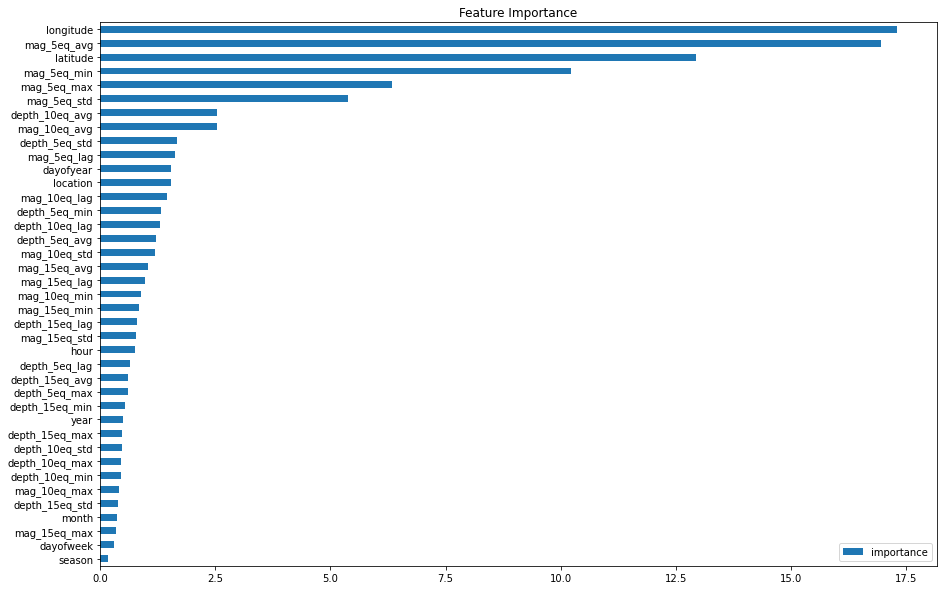

In [233]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(15, 10))
plt.show()

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Accuracy of Model: 0.8291690829279594
Mean Absolute Error: 0.34458523578380035
Root Mean Squared Error: 0.4697411059610845


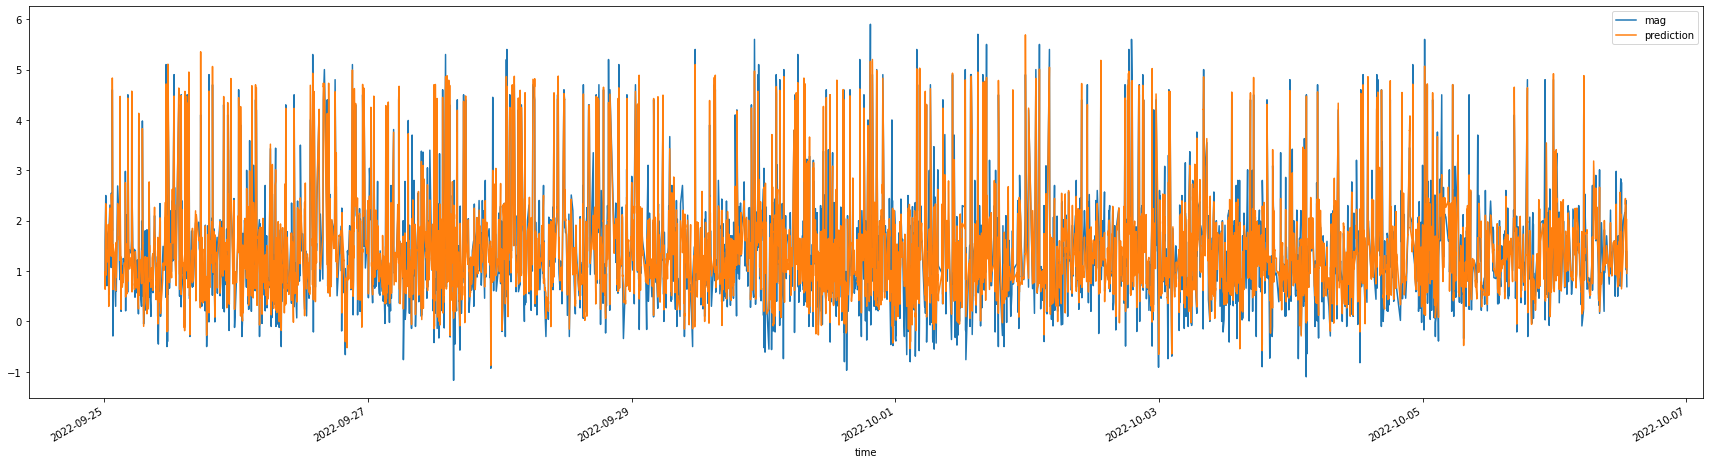

In [245]:
prediction = model.predict(df_test[features + cat_features])
print(f'Accuracy of Model: {model.score(df_test[features + cat_features], df_test[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(df_test[target], prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(df_test[target], prediction))}')

df_plot = pd.DataFrame({'time': df_test.time, 'mag': df_test[target], 'prediction': prediction})
df_plot = df_plot.sort_values(by='time')
df_plot.plot(figsize=(30, 8), x='time', y=['mag', 'prediction'])
plt.show()

In [248]:
live_data = pd.read_csv('https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&eventtype=earthquake')
live_data.time = pd.to_datetime(live_data.time)
live_data['location'] = live_data.place.str.split(', ', expand=True)[1]
live_data = live_data[::-1]

In [249]:
data = []
for location in live_data.location.unique():
    temp = live_data.loc[live_data.location == location]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_windows(temp)

    data.append(temp)

live_data = pd.concat(data)

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Accuracy of Model: 0.782088122175113
Mean Absolute Error: 0.39340243482955906
Root Mean Squared Error: 0.5289957045091795


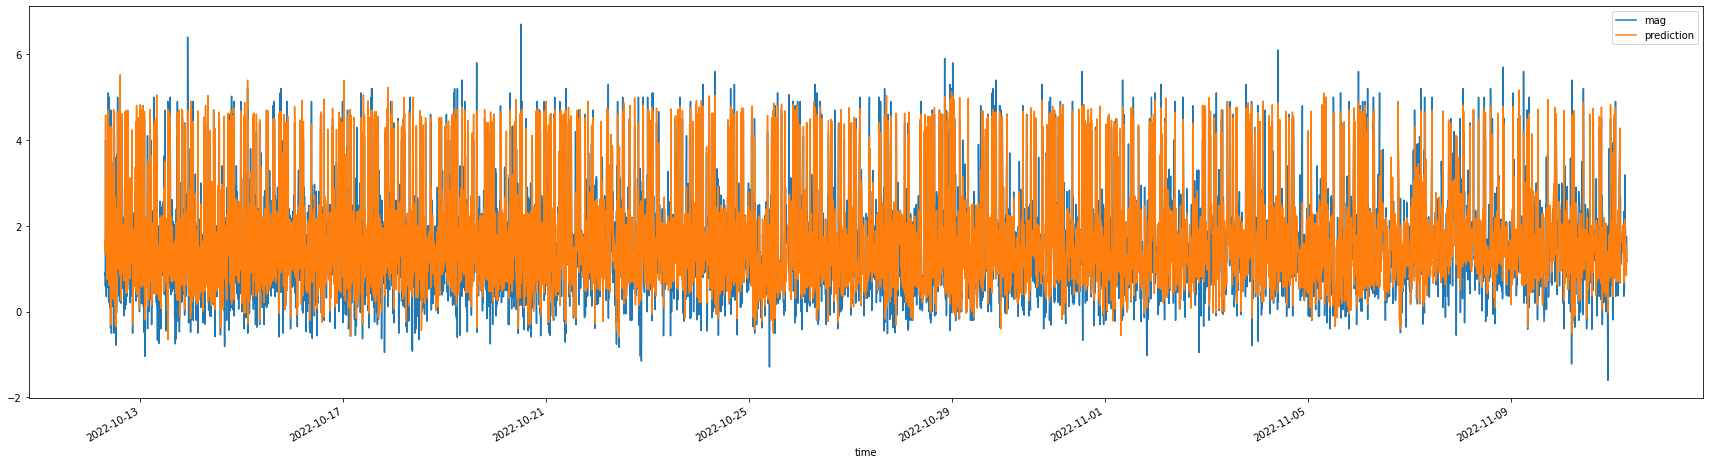

In [250]:
live_prediction = model.predict(live_data[features + cat_features])
print(f'Accuracy of Model: {model.score(live_data[features + cat_features], live_data[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(live_data[target], live_prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(live_data[target], live_prediction))}')

df_live = pd.DataFrame({'mag': live_data[target], 'prediction': live_prediction, 'time': live_data.time})
df_live = df_live.sort_values(by='time')
df_live.plot(figsize=(30, 8), x='time', y=['mag', 'prediction'])
plt.show()

In [251]:
# model.save_model('../app/server/app/ml/model')